## Part II - Super Resolution Using Feature Losses
Following on from the previous notebook - we want to improve our Generative model i.e. come up with a better loss function that not only achieves high resolution but also a deeper appreciation how the image actually looks. For example, we want a model that will generate textures that look right or animals with certain features that we expect to see.<br><br>This notion is presented by fastai and inspired by [Perceptual Losses for Real-Time Style Transfer
and Super-Resolution](https://arxiv.org/pdf/1603.08155.pdf). The idea here is that instead of using MSELoss on pixel values and a CrossEntropy loss for the Critic model, can we go deeper and compare the features displayed in the real image and the generated image. Let's discuss further:<br><br>
![perceptron](./images/perc.png)
_Johnson, et al. “Perceptual Losses for Real-Time Style Transfer and Super-Resolution.” Computer Vision – ECCV 2016 Lecture Notes in Computer Science, 2016, pp. 694–711._

An input image is passed through an _Image Transform Net_ (U-Nets have now become a more popular architecture). As the input goes through the encoder and then unpackaged in the decoder, the image is generated. This generated image is then passed through a pretrained model (previously these were vgg models however, resnets have since surpassed vgg image classification capabilities).<br><br>
NOTE: the output of this pretrained model would simply for image classification i.e. is the image a cat or a house etc.<br><br>
However, throughout the pretrained model, all these layers are being activated in various ways according to the inherent features that are present in that image. So what if instead of taking the output of the model, we take activations from various layers (or rather, feature maps) within the model. Each one of these feature maps is a semantic mapping of a specific feature i.e. the activations on one particular feature map might indicate the presence of fur and other feature map indicating the presence of an eyeball.<br><br>
And what if we then put the original image through the pretrained model, saved the activations at the same layers and compared these values to the previous image. We could in theory compare various feature maps on both images. For example, 3 layers (feature maps) on the original image might show: 
- fmap1(fur): high activation
- fmap2(stripes): high activation
- fmap3(blue color): high activation

And the generated image:
- fmap1(fur): high activation
- fmap2(stripes): high activation
- fmap3(blue color): low activation

This would indicate that there should be more blue in the generated image.<br>
By determining the loss across various feature maps, the Generative model would learn to improve it's methods in a much more refined way. From here, we have used features losses instead of the previous GAN process of creating a critic model. Let's see how it performs.

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [374]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [375]:
il = ImageItemList.from_folder(path_hr)

In [386]:
def resize_one(fn,i,path_dest=path_mr,path_orig=path_hr,sz=256):
    dest = path_dest/fn.relative_to(path_orig)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, sz, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [387]:
parallel(resize_one, il.items)

In [403]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [404]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [405]:
data = get_data(bs,size)

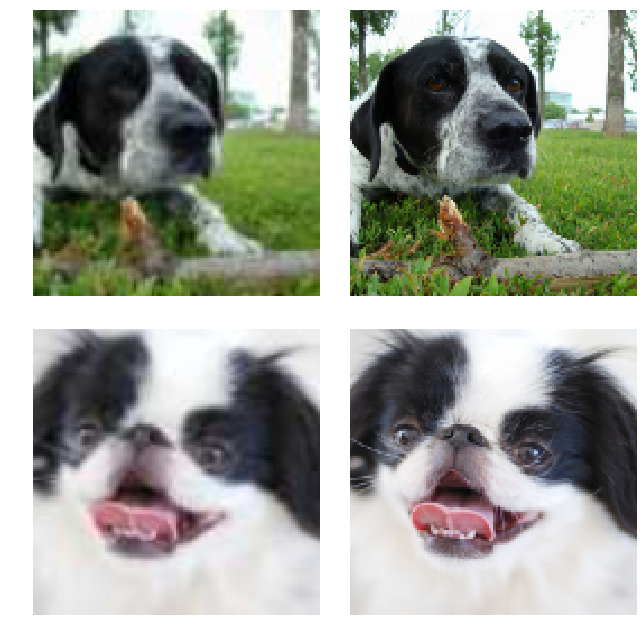

In [406]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [407]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [408]:
'''
A gram matrix is used to capture the similarity between two objects. 
More specifically, the matrix of each object (e.g. an image) is converted into a vector
and all these new vectors are grouped together to create a matrix M. Therefore:
G = M.T * M
where each element G(i,j) represents the similarity measure between image i and j
'''

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [409]:
gram_matrix(t)

tensor([[[0.0951, 0.1019, 0.0887],
         [0.1019, 0.1110, 0.0942],
         [0.0887, 0.0942, 0.0870]],

        [[0.0951, 0.1019, 0.0887],
         [0.1019, 0.1110, 0.0942],
         [0.0887, 0.0942, 0.0870]]])

In [410]:
# Loss Function Typically MSE or L1
base_loss = F.l1_loss

In [411]:
# model.features is the convolutional part of the model 
# (remember we don't need the output/head)
vgg_m = vgg16_bn(True).features.cuda().eval()
# we don't want to update the model, we want the values for the loss
requires_grad(vgg_m, False)

Below, we iterate over all the layers in the convulational part of the model and find all the max pooling layers. If you scroll up to the first graph, you will note that the feature maps are obtained from layers that are located right before a grid size change, thus we take `i-1` layer. Not suprisingly, as shown below, these are all ReLU layers with which we will get our values from.

In [412]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [413]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        # m_feat is the model with which we want to calculate the features
        self.m_feat = m_feat
        # grab all specific layers
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        # use hooks to grab the values of the intermediate values
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        """
        We pass through the target (y/out_feat) and the input (output of a generator)
        and get a copy of the stored activations at these layers.
        """
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        # input is the output of the generator model
        # target is the original image (y)
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        
        # Calculate the L1 ;oss of the pixels
        self.feat_losses = [base_loss(input,target)]
        
        # Calculate the L1 loss of all the features
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [414]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [415]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


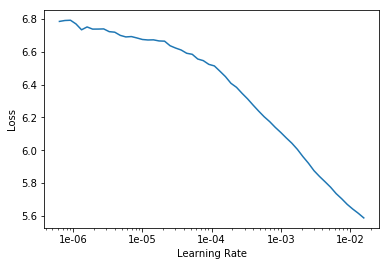

In [416]:
learn.lr_find()
learn.recorder.plot()

In [417]:
lr = 1e-3

In [418]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,3.899971,3.754559,0.145393,0.230504,0.316724,0.224630,0.568471,1.214124,1.054713
2,3.759398,3.635579,0.145231,0.227358,0.309213,0.217535,0.535335,1.178309,1.022598
3,3.698555,3.553379,0.150049,0.226932,0.303647,0.212319,0.519746,1.139054,1.001631
4,3.633785,3.461974,0.144817,0.225927,0.300109,0.206665,0.492265,1.118373,0.973819
5,3.588929,3.399250,0.140298,0.221959,0.294438,0.202816,0.487147,1.094835,0.957757
6,3.514236,3.375652,0.145250,0.219295,0.290526,0.200674,0.484132,1.087391,0.948385
7,3.510545,3.321257,0.140585,0.220403,0.289096,0.198635,0.467989,1.067553,0.936997
8,3.461642,3.271542,0.135425,0.216449,0.284894,0.194695,0.463778,1.055891,0.920409
9,3.428299,3.243044,0.137380,0.217691,0.284320,0.193701,0.450314,1.046798,0.912840
10,3.355466,3.146061,0.133120,0.214981,0.278065,0.187448,0.429021,1.019413,0.884013


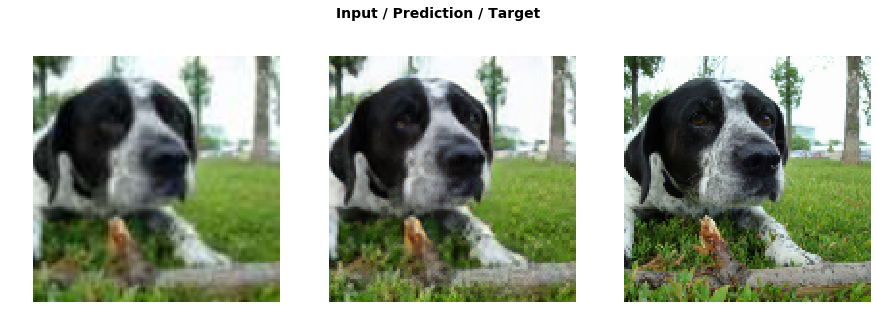

In [419]:
do_fit('1a', slice(lr*10))

In [420]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,3.316198,3.138767,0.132496,0.214404,0.277240,0.186876,0.429591,1.017226,0.880935
2,3.311727,3.133698,0.132345,0.214175,0.276811,0.186567,0.428779,1.015463,0.879559
3,3.317270,3.133279,0.132287,0.214286,0.276637,0.186415,0.429170,1.015277,0.879208
4,3.292712,3.124722,0.132470,0.214022,0.276086,0.186079,0.425525,1.012430,0.878110
5,3.309118,3.118006,0.132631,0.213825,0.275909,0.185821,0.424195,1.009643,0.875981
6,3.298452,3.112339,0.132725,0.213420,0.275416,0.185666,0.420998,1.007351,0.876763
7,3.295548,3.117472,0.133409,0.213282,0.275082,0.185945,0.421853,1.009338,0.878563
8,3.276701,3.106738,0.132407,0.213142,0.274784,0.185242,0.421416,1.005008,0.874739
9,3.303375,3.097376,0.131427,0.212388,0.274056,0.183978,0.422029,1.005106,0.868392
10,3.268549,3.084780,0.132302,0.212457,0.273478,0.183822,0.416181,0.999467,0.867074


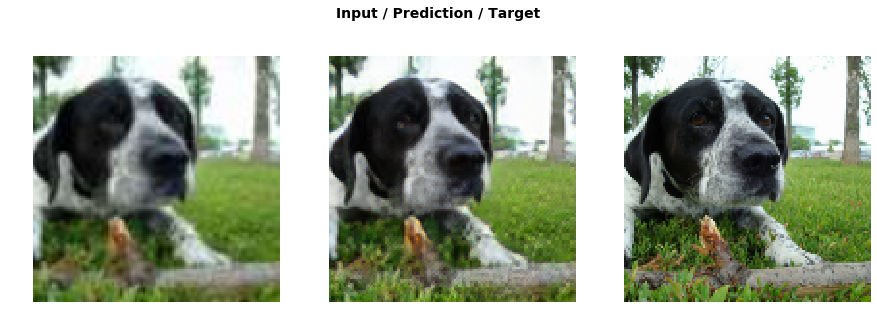

In [421]:
do_fit('1b', slice(1e-5,1e-3))

In [422]:
# Now lets increase the image size (and halve the batch size)
data = get_data(bs//2,size*2)
learn.data = data
learn.freeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.245395,2.208137,0.160240,0.259266,0.295081,0.155465,0.386219,0.582753,0.369113
2,2.217161,2.188044,0.161069,0.259936,0.294335,0.154628,0.375374,0.577702,0.365000
3,2.181215,2.156496,0.160494,0.258699,0.291910,0.153286,0.363247,0.568085,0.360775
4,2.163355,2.145721,0.162375,0.260089,0.291648,0.152670,0.355298,0.565310,0.358332
5,2.143685,2.133257,0.163788,0.259324,0.289404,0.151475,0.351760,0.562113,0.355394
6,2.138432,2.111061,0.160139,0.256860,0.286636,0.149355,0.351016,0.554913,0.352142
7,2.103319,2.113546,0.163950,0.258187,0.286667,0.149347,0.347666,0.556388,0.351340
8,2.113076,2.095229,0.161672,0.256485,0.284761,0.147699,0.342806,0.554128,0.347679
9,2.096508,2.084508,0.162703,0.256797,0.284340,0.148108,0.337007,0.547589,0.347964
10,2.062811,2.071733,0.162827,0.256508,0.283560,0.147170,0.332621,0.543535,0.345511


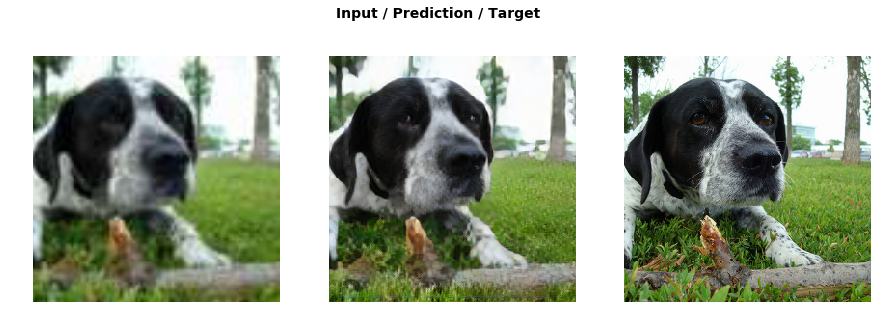

In [423]:
do_fit('2a')

In [424]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.079952,2.070279,0.162180,0.256237,0.282882,0.146764,0.333796,0.543601,0.344819
2,2.076227,2.067849,0.161200,0.255601,0.282271,0.146539,0.334519,0.543339,0.344380
3,2.074329,2.067932,0.161946,0.255978,0.282745,0.146598,0.332939,0.543556,0.344170
4,2.063120,2.064836,0.161740,0.255841,0.282307,0.146414,0.332265,0.542601,0.343668
5,2.057271,2.063763,0.161778,0.255889,0.282102,0.145924,0.332773,0.542159,0.343138
6,2.061974,2.061860,0.161662,0.255419,0.281913,0.146280,0.331881,0.541425,0.343280
7,2.060795,2.062404,0.162711,0.256336,0.282516,0.146263,0.330113,0.541277,0.343189
8,2.050660,2.059723,0.162343,0.256079,0.282162,0.146200,0.329615,0.540252,0.343072
9,2.069597,2.059036,0.161741,0.255755,0.282106,0.145967,0.329980,0.540795,0.342693
10,2.066029,2.058845,0.161980,0.255563,0.281972,0.145948,0.330426,0.540390,0.342564


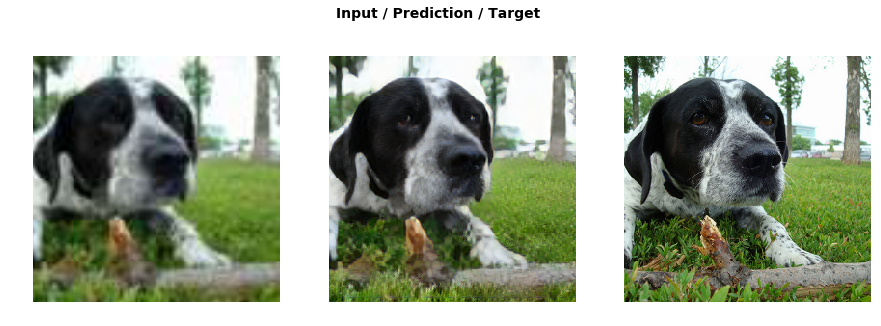

In [425]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [432]:
data_mr = (ImageImageList.from_folder(path_mr).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=(256,340), tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))

In [433]:
learn.data = data_mr

In [439]:
fn = data_mr.valid_ds.x.items[1]; fn
img = open_image(fn); img.shape
_,img_hr,b = learn.predict(img)

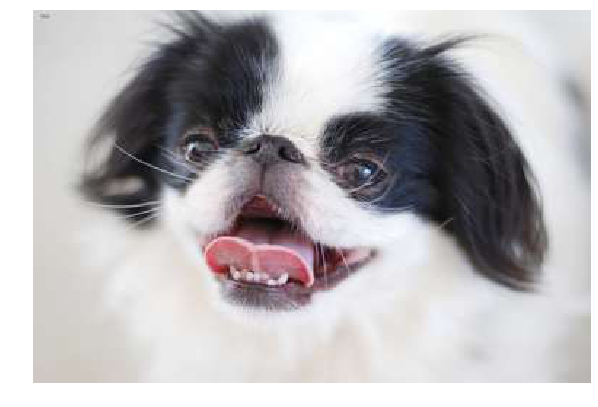

In [442]:
show_image(img, figsize=(10,8), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


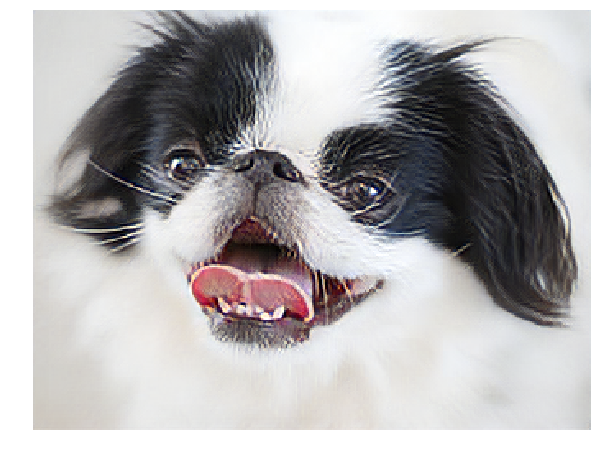

In [443]:
Image(img_hr).show(figsize=(10,8))